In [16]:
import matplotlib.pyplot as plt
import numpy as np

# DEFINICION DE INTEGRADOR TEMPORAL
def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

# DEFINICION DE SISTEMA DE ECUACIONES
def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == "PT_waveguide":
        U = field_slices[0]
        V = field_slices[1]

        k = parameters[0]
        gamma = parameters[1]
        beta0 = parameters[2]
        delta = parameters[3]
        dbeta = parameters[4]
        w = parameters[5]
        beta_gain = beta0 + dbeta * np.cos(w * t_i)
        beta_loss = beta0

        F = 1j * k * V - 1j * gamma * (U / (1 + np.abs(U) ** 2)) + (beta_gain + 1j * delta) * U
        G = 1j * k * U - 1j * gamma * (V / (1 + np.abs(V) ** 2)) - (beta_loss + 1j * delta) * V

        fields = np.array([F, G])
    return fields

In [71]:
eq = "PT_waveguide"
t_rate = 1

# PARAMETROS (GAMMA = POTENCIAL, K = ACOPLE, ALPHA = GAIN - LOSS)
gamma = 10.0
k = 1.0
beta = 0.6
delta = 0.0
dbeta = 0.01
w = 2/69

# PARAMETROS INICIALES DE POTENCIA (N) Y PHASE INICIAL DE PRIMER OSCILADOR
N = 20.0
theta_init = 0.0

###### PHASE DIFFERENCE STATIONARY POINTS ######
phi_0 = np.arcsin(beta / k)
phi_1 = np.pi - np.arcsin(beta / k)

###### POWER IMBALANCE STATIONARY POINTS ######

### TRIVIAL SOLUTION ###
z_0 = 0.0

### n = 0 o PHASE DIFFERENCE = 0 ###
n = 0
z_pp_0 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) + ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mm_0 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) - ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_pm_0 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) - ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mp_0 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) + ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5

### n = 1 o PHASE DIFFERENCE = pi ###

n = 1
z_pp_1 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) + ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mm_1 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) - ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_pm_1 = +((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) - ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5
z_mp_1 = -((N + 2) ** 2 - (2 * gamma ** 2) / (k ** 2) + ((2 * gamma) / (k ** 2)) * (
            gamma ** 2 - 4 * k * (-1) ** n * (1 + N)) ** 0.5) ** 0.5


### DEFINIENDO Z CON UNA PERTURBACIÓN PEQUEÑA PARA VER ORBITAS O PUNTOS SILLA ###
dz = 0.1
z = z_0 + dz

# CONDICIONES INICIALES EN TERMINOS DE R Y PHASE DIFF (OJO, SE SIMULAN DIRECTAMENTE COMO CAMPO COMPLEJO, RESULTADOS COMPARADOS CON SISTEMA EN TERMINOS DE CAMPOS REALES VS IMAGINARIOS)
R1 = np.sqrt((N - z) / 2)
R2 = np.sqrt((N + z) / 2)
U_init = R1 * np.exp(1j * theta_init)
V_init = R2 * np.exp(1j * (theta_init + phi_0))

# DEFINICIÓN DE GRILLA TEMPORAL, ESPACIAL SE DEFINE COMO ARRAY CERO POR COMO FUNCIONA EL CODIGO
[tmin, tmax, dt] = [0, 8000, 0.025]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
x_grid = np.array([0])           # SPATIAL GRID DEFINITION
T = tmax
Nt = t_grid.shape[0]
operators = [0]
fields_init = [U_init, V_init]
grids = [t_grid, x_grid, 0]
parameters_np = np.array([k, gamma, beta, delta, dbeta, w])

# SIMULACIÓN NUMERICA
final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)      #NUMERICAL SIMULATION

# REOBTENIENDO DATOS DE SIMULACIÓN
U = np.array(fields_history)[:, 0]
V = np.array(fields_history)[:, 1]
lightness = 1
U_light = U[0::lightness]
V_light = V[0::lightness]
t_light = np.array(time_grid[0::lightness])
P1 = np.abs(U_light) ** 2
P2 = np.abs(V_light) ** 2

# REDEFINIENDO VARIABLES EN N, Z Y PHI
N_variable = P1 + P2
z_variable = P2 - P1
arg_variable = np.angle(U_light * np.conjugate(V_light))

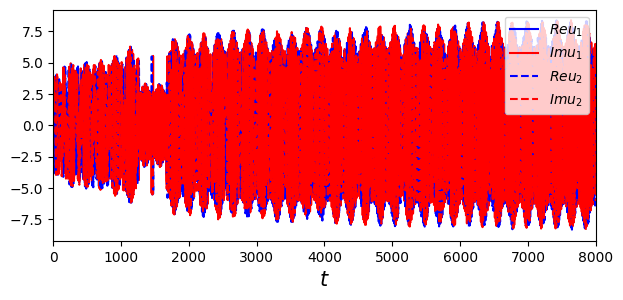

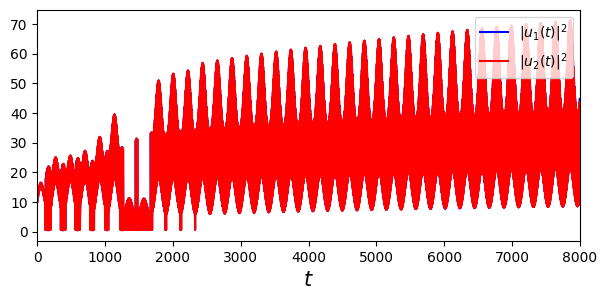

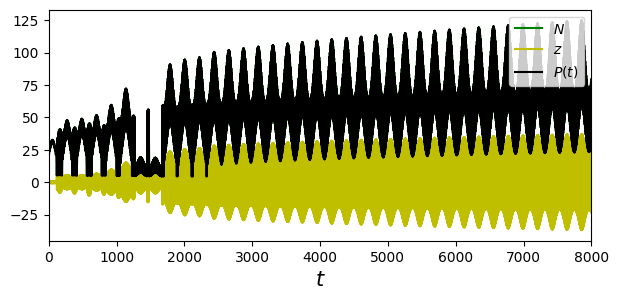

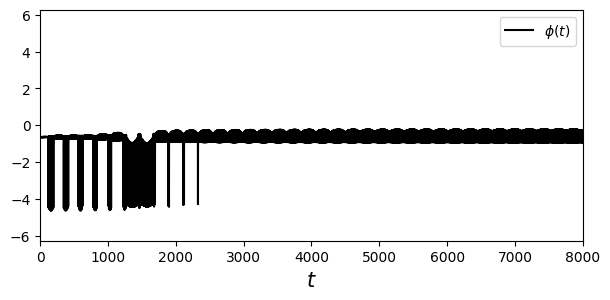

Text(0.5, 0, '$\\phi$')

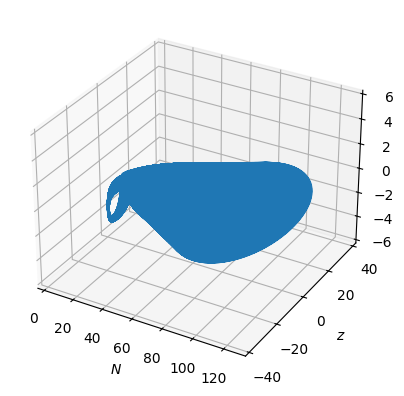

In [70]:
############### GENERIC INITIAL AND FINAL TIME ###############
t_init = 0
t_final = 8000
i_0 = np.argmin(np.abs(t_light - t_init))
i_f = np.argmin(np.abs(t_light - t_final))

############### GRAFICO DE P1, P2 Y P EN EL TIEMPO ###############

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(t_light[i_0:i_f], np.real(U_light[i_0:i_f]), color='b', label="$Re u_1$")
ax.plot(t_light[i_0:i_f], np.imag(U_light[i_0:i_f]), color='r', label="$Im u_1$")
ax.plot(t_light[i_0:i_f], np.real(V_light[i_0:i_f]), color='b', label="$Re u_2$", ls="--")
ax.plot(t_light[i_0:i_f], np.imag(V_light[i_0:i_f]), color='r', label="$Im u_2$", ls="--")
#ax.plot(t_light[i_0:i_f], P1[i_0:i_f] + P2[i_0:i_f], color='k', label="$P(t)$")
ax.legend(fontsize=10, loc="upper right")
ax.set_xlabel("$t$", fontsize=15)
ax.set_xlim(t_init, t_final)
plt.show()
plt.close()

############### GRAFICO DE P1, P2 Y P EN EL TIEMPO ###############

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(t_light[i_0:i_f], P1[i_0:i_f], color='b', label="$|u_1(t)|^2$")
ax.plot(t_light[i_0:i_f], P2[i_0:i_f], color='r', label="$|u_2(t)|^2$")
#ax.plot(t_light[i_0:i_f], P1[i_0:i_f] + P2[i_0:i_f], color='k', label="$P(t)$")
ax.legend(fontsize=10, loc="upper right")
ax.set_xlabel("$t$", fontsize=15)
ax.set_xlim(t_init, t_final)
plt.show()
plt.close()

############### GRAFICO DE N1, N2 Y N EN EL TIEMPO ###############

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(t_light[i_0:i_f], P2[i_0:i_f] + P1[i_0:i_f], color='g', label="$N$")
ax.plot(t_light[i_0:i_f], P2[i_0:i_f] - P1[i_0:i_f], color='y', label="$z$")
ax.plot(t_light[i_0:i_f], P1[i_0:i_f] + P2[i_0:i_f], color='k', label="$P(t)$")
ax.legend(fontsize=10, loc="upper right")
ax.set_xlabel("$t$", fontsize=15)
ax.set_xlim(t_init, t_final)
plt.show()
plt.close()

############### GRAFICO DE P1, P2 Y P EN EL TIEMPO ###############

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(t_light[i_0:i_f], np.unwrap(arg_variable, axis=0)[i_0:i_f], color='k', label="$\\phi(t)$")
ax.legend(fontsize=10, loc="upper right")
ax.set_xlabel("$t$", fontsize=15)
ax.set_xlim(t_init, t_final)
ax.set_ylim([-2*np.pi, 2*np.pi])
plt.show()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(N_variable, z_variable, np.unwrap(arg_variable, axis=0), label='3D curve')  # or use ax.scatter3D(x, y, z) for scatter
ax.set_zlim([-2*np.pi, 2*np.pi])
ax.set_xlabel('$N$')
ax.set_ylabel('$z$')
ax.set_zlabel(r'$\phi$')